In [1]:
!date

Wed Feb 12 10:08:21 PST 2020


# Restricting to two isoform genes

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
isoform = anndata.read_h5ad("cell_ranger_annotation/isoform.h5ad")
gene =    anndata.read_h5ad("cell_ranger_annotation/gene.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Restrict analysis to two isoform genes

In [3]:
gene

AnnData object with n_obs × n_vars = 6043 × 20586 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'txn_list', 'num_isoforms', 'gene_TPM', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'

In [4]:
gene = gene[:,gene.var["num_isoforms"]==2]

In [5]:
gene

View of AnnData object with n_obs × n_vars = 6043 × 2970 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'txn_list', 'num_isoforms', 'gene_TPM', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'

In [6]:
%%time
transcripts = []
l = gene.var.txn_list.values
for sublist in l:
    sublist = ast.literal_eval(sublist)
    for item in sublist:
        transcripts.append(item)

CPU times: user 34.8 ms, sys: 0 ns, total: 34.8 ms
Wall time: 34.2 ms


In [7]:
isoform

AnnData object with n_obs × n_vars = 6043 × 84364 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'gene_TPM', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'

In [8]:
isoform = isoform[:,isoform.var["transcript_id"].isin(transcripts)]

In [9]:
isoform

View of AnnData object with n_obs × n_vars = 6043 × 5940 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'gene_TPM', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'

# Continue analysis

### One example before iterating

In [10]:
c = "Vip"

In [11]:
tmp1 = isoform[isoform.obs["subclass_label"] == c]
tmp2 = isoform[isoform.obs["subclass_label"] != c]

In [12]:
tmp1

View of AnnData object with n_obs × n_vars = 555 × 5940 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'gene_TPM', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'

In [13]:
tmp_mat = tmp1[:, tmp1.var["gene_name"] == "Tcea1"].layers["log1p"].todense()[0:10]
tmp_mat

matrix([[6.6174803, 2.8098001],
        [5.4166293, 0.       ],
        [5.965857 , 0.       ],
        [4.6191125, 0.       ],
        [5.9912596, 1.6766927],
        [4.9703965, 3.8514297],
        [6.0745597, 0.       ],
        [5.466261 , 0.       ],
        [6.181564 , 0.       ],
        [4.9122944, 2.605892 ]], dtype=float32)

In [14]:
tmp_mat = tmp1[:, tmp1.var["gene_name"] == "Tcea1"].layers["log1p"].todense()[0:10]
tmp_mat

matrix([[6.6174803, 2.8098001],
        [5.4166293, 0.       ],
        [5.965857 , 0.       ],
        [4.6191125, 0.       ],
        [5.9912596, 1.6766927],
        [4.9703965, 3.8514297],
        [6.0745597, 0.       ],
        [5.466261 , 0.       ],
        [6.181564 , 0.       ],
        [4.9122944, 2.605892 ]], dtype=float32)

In [15]:
def normalize_rows_L1(mat):
    L1 = mat.sum(axis=1)
    norm = mat/L1[:,None]
    return norm

In [16]:
normalize_rows_L1(np.asarray(tmp_mat))

array([[0.7019501 , 0.29804993],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.7813376 , 0.21866238],
       [0.56342036, 0.43657964],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.6533882 , 0.34661177]], dtype=float32)

# Make a new adata on isoform ratios with two isoform genes
Should be the same shape as gene adata
Then use scanpy highly variable genes on that adata and also on the gene adata, compare results

In [17]:
isoform.var["idx"] = np.arange(isoform.shape[1])
gene.var["idx"] = np.arange(gene.shape[1])

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


In [18]:
gene_id = gene.var["gene_id"].values
gene_names = gene.var["gene_name"].values.astype(str)
ngenes = gene_names.shape[0]
ncells = gene.shape[0]
clusters = gene.obs["subclass_label"].unique().astype(str)
nclusters = clusters.shape[0]

In [19]:
transcripts = isoform.var.transcript_id.values
txn_indices = isoform.var.idx.values
t2idx = dict(zip(txn_indices, transcripts))

g2tidx = isoform.var.groupby("gene_id")["idx"].apply(list)
mtx = np.zeros((ncells, ngenes))
X = isoform.layers["log1p"].todense()
for idx, g in enumerate(gene_id):
    txns = g2tidx[g]
    
    sub_mtx = np.asarray(X[:, txns]).reshape(-1,2)
    
    sub_mtx = normalize_rows_L1(sub_mtx)
    
    mtx[:,idx] = np.asarray(sub_mtx)[:,0]
    if idx%4000 == 0:
        print(idx)
        
var = pd.DataFrame({'gene_id':gene_id, "gene_name":gene_names})
iso_ratio = anndata.AnnData(X=csr_matrix(mtx), obs=isoform.obs, var=var)

0


Transforming to str index.


In [20]:
type(np.asarray(iso_ratio.X.todense()[:,0][0:10])[0][0])

numpy.float32

In [21]:
isoform[:,isoform.var.gene_id=="ENSMUSG00000102343"].layers["log1p"].todense()[0:10]

matrix([[0.        , 0.        ],
        [0.        , 1.0986123 ],
        [0.        , 0.        ],
        [0.        , 2.1972246 ],
        [0.        , 0.        ],
        [0.        , 0.81788373],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.6931472 ]], dtype=float32)

In [22]:
tmp = np.asarray(isoform[:,isoform.var.gene_id=="ENSMUSG00000102343"].layers["log1p"].todense()[0:10]).reshape(-1, 2)
normalize_rows_L1(tmp)

array([[nan, nan],
       [ 0.,  1.],
       [nan, nan],
       [ 0.,  1.],
       [nan, nan],
       [ 0.,  1.],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [ 0.,  1.]], dtype=float32)

In [23]:
np.isnan(iso_ratio.X.todense())

matrix([[ True,  True, False, ...,  True,  True, False],
        [False,  True, False, ..., False,  True, False],
        [ True,  True, False, ..., False,  True, False],
        ...,
        [ True,  True, False, ..., False,  True, False],
        [ True,  True, False, ..., False,  True, False],
        [ True,  True, False, ..., False,  True, False]])

## Now do t-test between isoform shifts in clusters

Making a DE function to do this the right way

In [24]:
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')



def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, method):
    nfeat = pval.shape[1]
    
    if method == 'benjamini-hochberg':
        _, pval_corr, _, _ = multipletests(pval, alpha=0.05, method='fdr_bh')
    elif method == 'bonferroni':
        pval_corr = np.minimum(pval * nfeat, 1.0)
        
    return pval_corr

def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    corr_method = kwargs.get("corr_method", "bonferroni")
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan
        
        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((~np.isnan(t_mat)).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        #print(t_mat.shape)
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="omit")
            pvalue = test.pvalue
            statistic = test.statistic
        
        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic

    pval_corr = correct_pval(pval, corr_method)
    
    return (pval, pval_corr, stat)

In [25]:
%%time
nc = 10
nf = 10

mat         = gene.layers["log1p"][:nc,:nf]
components  = gene.obs.cell_id.values[:nc]
features    = gene.var.gene_name.values[:nf]
assignments = gene.obs.subclass_label.values[:nc]

# %lprun -f dexpress dexpress(mat, components, features, assignments)
pval, pval_corr, stat = dexpress(mat, components, features, assignments)

23-Feb-20 17:04:57 - 1 of 5 assignments: L5 IT
23-Feb-20 17:04:57 - 2 of 5 assignments: L5/6 NP
23-Feb-20 17:04:57 - 3 of 5 assignments: Lamp5
23-Feb-20 17:04:57 - 4 of 5 assignments: Sst
23-Feb-20 17:04:57 - 5 of 5 assignments: Vip


CPU times: user 14.1 ms, sys: 2.48 ms, total: 16.6 ms
Wall time: 14.6 ms


In [81]:
%%time
mat         = gene.layers["log1p"]
components  = gene.obs.cell_id.values
features    = gene.var.gene_name.values
assignments = gene.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"

pval, pval_corr, stat = dexpress(mat, components, 
                                features, assignments, 
                                corr_method=corr_method, 
                                nan_cutoff=nan_cutoff)

23-Feb-20 17:45:35 - 1 of 18 assignments: Astro
23-Feb-20 17:45:35 - 2 of 18 assignments: Endo
23-Feb-20 17:45:35 - 3 of 18 assignments: L2/3 IT
23-Feb-20 17:45:36 - 4 of 18 assignments: L5 ET
23-Feb-20 17:45:36 - 5 of 18 assignments: L5 IT
23-Feb-20 17:45:36 - 6 of 18 assignments: L5/6 NP
23-Feb-20 17:45:36 - 7 of 18 assignments: L6 CT
23-Feb-20 17:45:36 - 8 of 18 assignments: L6 IT
23-Feb-20 17:45:37 - 9 of 18 assignments: L6 IT Car3
23-Feb-20 17:45:37 - 10 of 18 assignments: L6b
23-Feb-20 17:45:37 - 11 of 18 assignments: Lamp5
23-Feb-20 17:45:37 - 12 of 18 assignments: Low Quality
23-Feb-20 17:45:37 - 13 of 18 assignments: Pvalb
23-Feb-20 17:45:37 - 14 of 18 assignments: SMC
23-Feb-20 17:45:38 - 15 of 18 assignments: Sncg
23-Feb-20 17:45:38 - 16 of 18 assignments: Sst
23-Feb-20 17:45:38 - 17 of 18 assignments: VLMC
23-Feb-20 17:45:38 - 18 of 18 assignments: Vip


CPU times: user 2.89 s, sys: 469 ms, total: 3.36 s
Wall time: 3.35 s


In [93]:
%%time
mat         = iso_ratio.X.todense()
components  = iso_ratio.obs.cell_id.values
features    = iso_ratio.var.gene_name.values
assignments = iso_ratio.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.75 # 50% of elements in cluster
corr_method = "bonferroni"

pval_iso, pval_iso_corr, stat_iso = dexpress(mat, components, 
                                             features, assignments, 
                                             corr_method=corr_method, 
                                              nan_cutoff=nan_cutoff)

23-Feb-20 22:11:31 - 1 of 18 assignments: Astro
23-Feb-20 22:11:31 - 2 of 18 assignments: Endo
23-Feb-20 22:11:31 - 3 of 18 assignments: L2/3 IT
23-Feb-20 22:11:31 - 4 of 18 assignments: L5 ET
23-Feb-20 22:11:31 - 5 of 18 assignments: L5 IT
23-Feb-20 22:11:31 - 6 of 18 assignments: L5/6 NP
23-Feb-20 22:11:31 - 7 of 18 assignments: L6 CT
23-Feb-20 22:11:32 - 8 of 18 assignments: L6 IT
23-Feb-20 22:11:32 - 9 of 18 assignments: L6 IT Car3
23-Feb-20 22:11:32 - 10 of 18 assignments: L6b
23-Feb-20 22:11:32 - 11 of 18 assignments: Lamp5
23-Feb-20 22:11:32 - 12 of 18 assignments: Low Quality
23-Feb-20 22:11:32 - 13 of 18 assignments: Pvalb
23-Feb-20 22:11:33 - 14 of 18 assignments: SMC
23-Feb-20 22:11:33 - 15 of 18 assignments: Sncg
23-Feb-20 22:11:33 - 16 of 18 assignments: Sst
23-Feb-20 22:11:33 - 17 of 18 assignments: VLMC
23-Feb-20 22:11:33 - 18 of 18 assignments: Vip


CPU times: user 1.9 s, sys: 636 ms, total: 2.53 s
Wall time: 2.52 s


In [29]:
def plot_yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()])]  # max of both axes
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

23-Feb-20 17:45:55 - update_title_pos
23-Feb-20 17:45:56 - update_title_pos
23-Feb-20 17:45:56 - update_title_pos
23-Feb-20 17:45:56 - update_title_pos


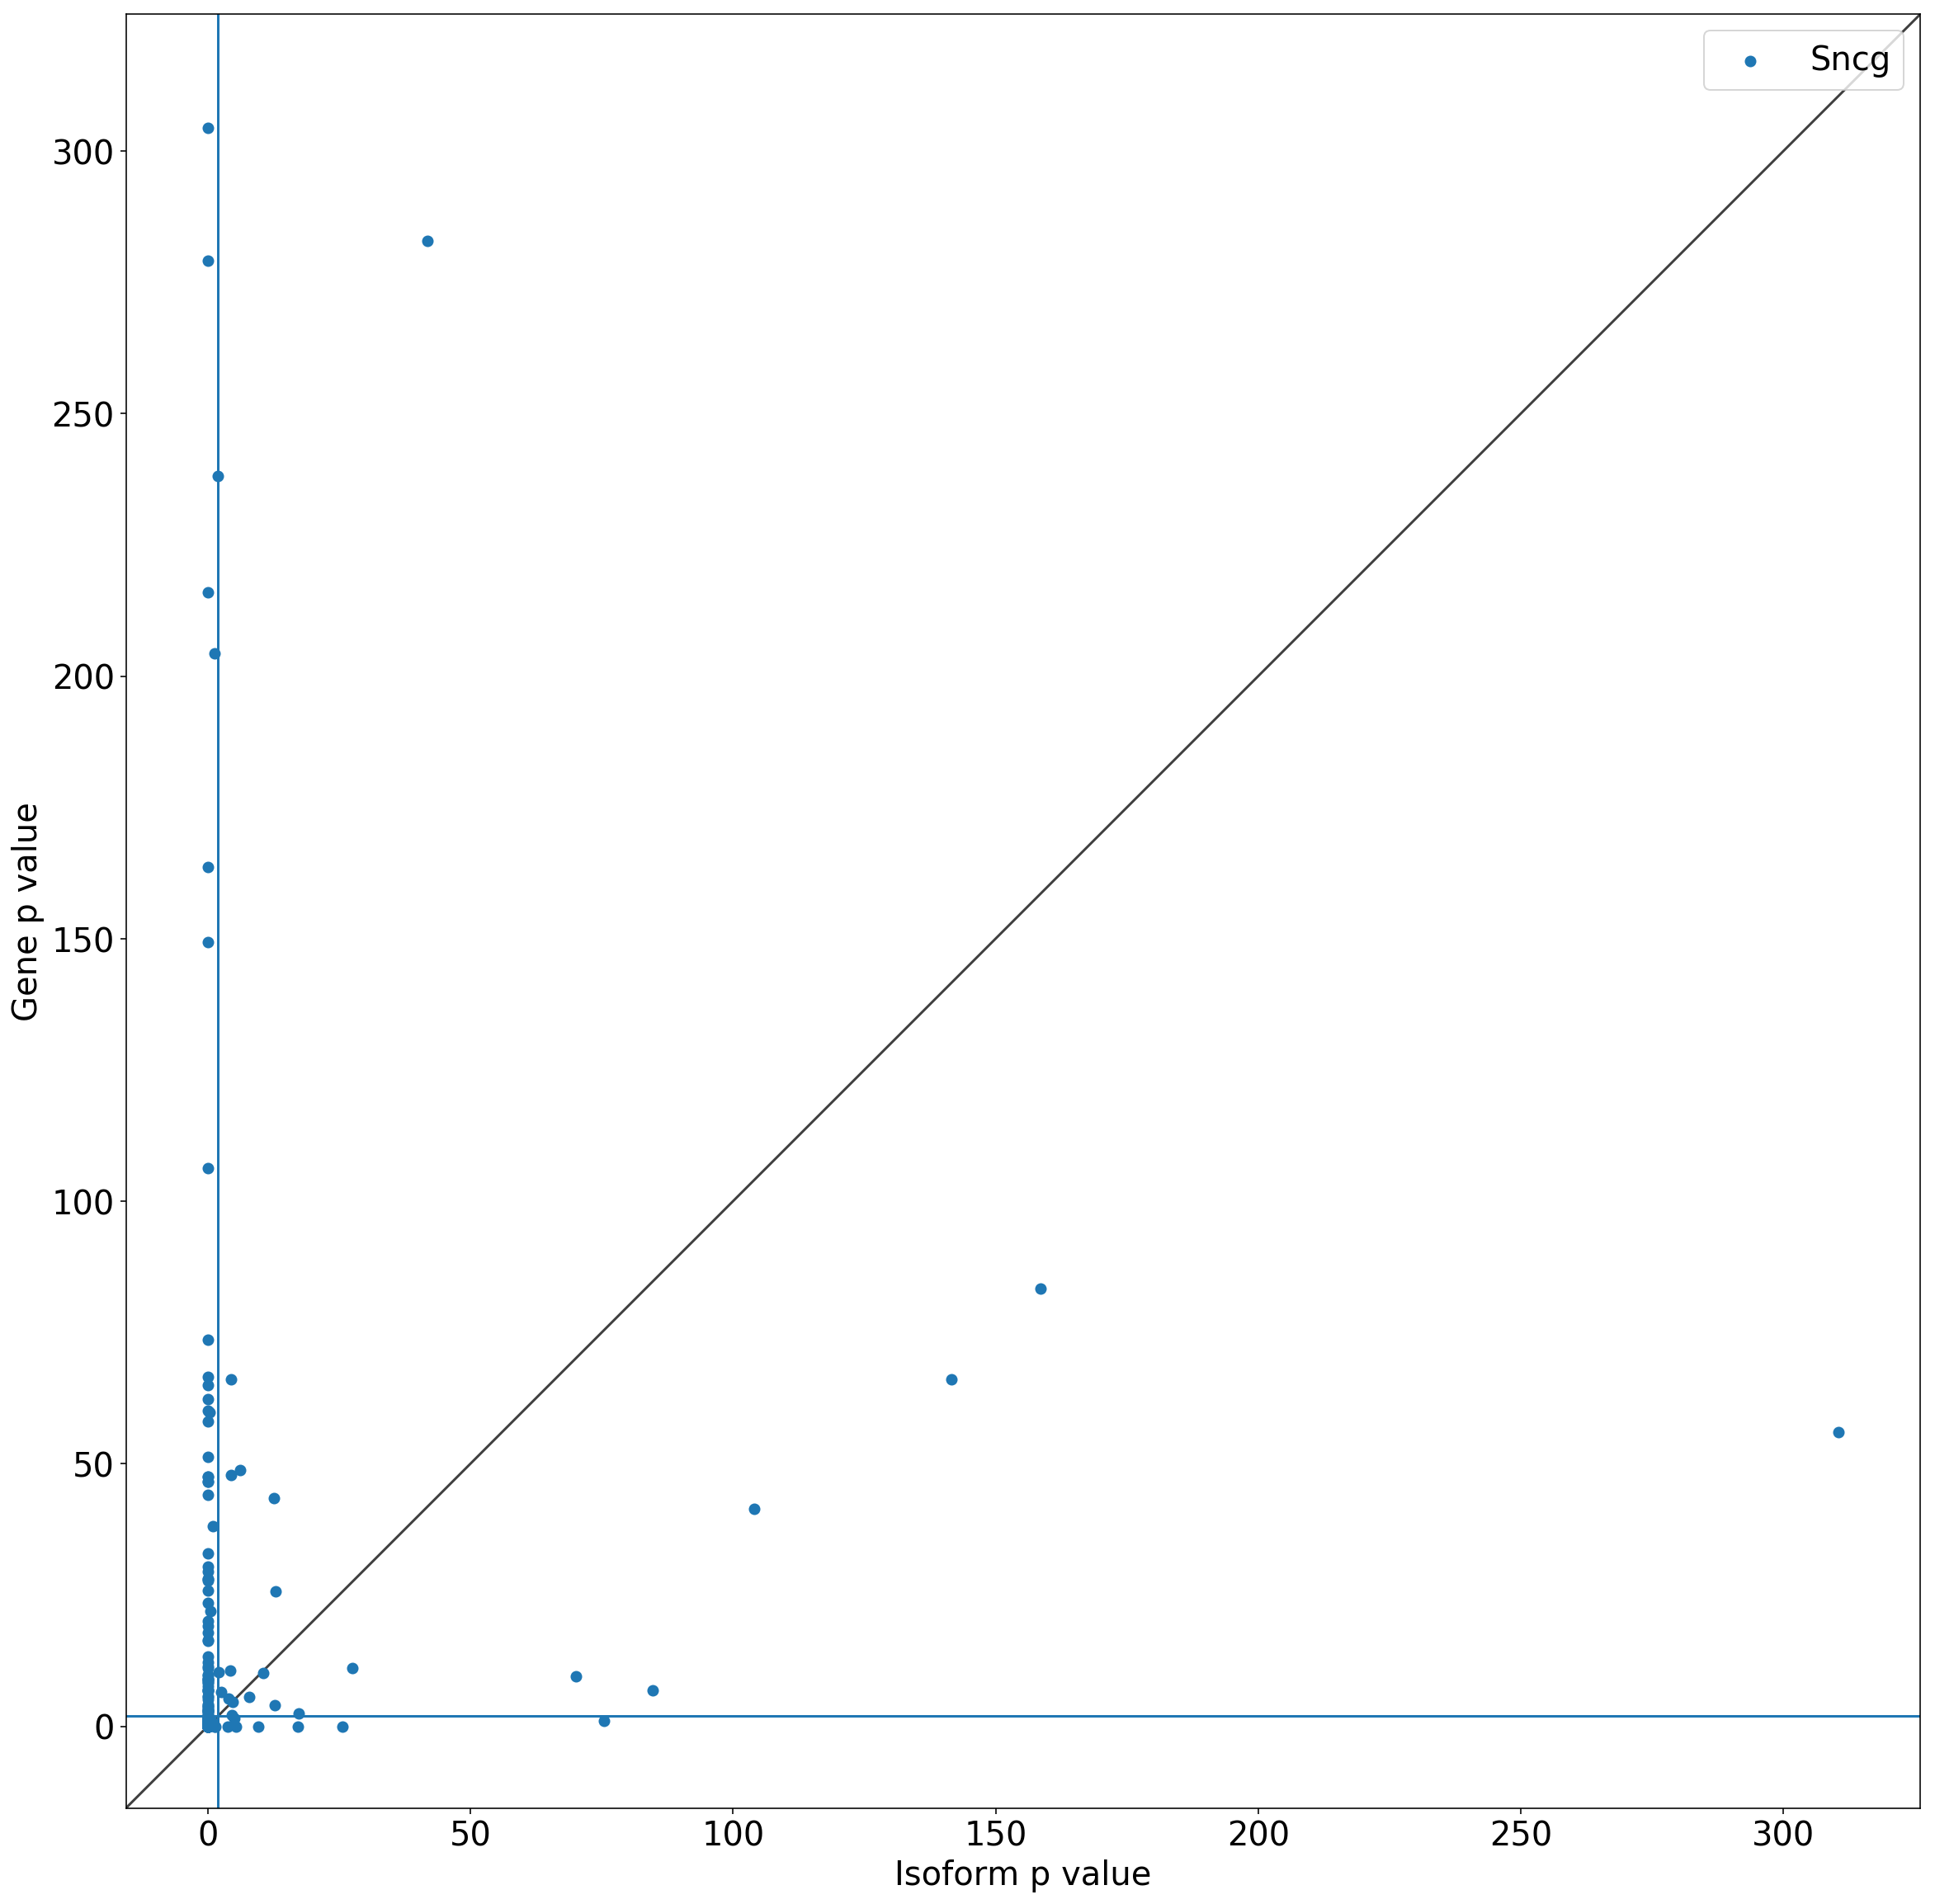

In [83]:
fig, ax = plt.subplots(figsize=(20,20))

cnum = -2

mask = np.logical_and(~np.isnan(pval_corr[cnum]), ~np.isnan(pval_iso_corr[cnum]))

n_isotests = (~np.isnan(pval_iso_corr[cnum])).sum()
n_genetests = (~np.isnan(pval_corr[cnum])).sum()

x = -np.log10(pval_iso_corr[cnum][mask])
y = -np.log10(pval_corr[cnum][mask])

line = -np.log10(.01)#/(n_isotests + n_genetests))

ax.scatter(x, y, label=assignments[cnum])
ax.axvline(x=line)
ax.axhline(y=line)

ax.set_xlabel('Isoform p value')
ax.set_ylabel('Gene p value')

ax = plot_yex(ax)


# for i, txt in enumerate(gene_names[mask]):
#     if x[i] > line or y[i]>line:
#         ax.annotate(txt, (x[i], y[i]), fontsize=fsize-5, rotation=90)
ax.legend(loc='upper right')

plt.show()

In [84]:
def mask_top_features(p1, p2, alpha):
    nan_mask = np.logical_and(~np.isnan(p1), ~np.isnan(p2))
    threshold_mask = np.logical_and(p1<alpha, p2>alpha)
    
    mask = np.logical_and(nan_mask, threshold_mask)
    return mask

def print_top_features(features, pval_1, pval_2, cnum=0, return_pvals=False, feature="gene"):
    p1 = -np.log10(pval_1[cnum])
    p2 = -np.log10(pval_2[cnum])
    
    alpha = -np.log10(0.05)
    
    mask = mask_top_features(p1, p2, alpha)
    psort = np.argsort(p2[mask])
    if return_pvals==True and feature=="gene":
        return p1[mask][psort]
    elif return_pvals==True and feature=="isoform":
        return p2[mask][psort]
    
    return features[mask][psort]

In [44]:
print_top_features(features, pval_corr, pval_iso_corr, cnum=-2)

[Slc39a2, Dhrs7b, Cdc42]
Categories (2970, object): [0610009B22Rik, 0610038B21Rik, 0610040F04Rik, 0610043K17Rik, ..., Zpbp2, Zscan26, Zswim1, Zyg11b]

In [34]:
from collections import defaultdict

In [94]:
d = defaultdict()
ng = 20
for i in range(ng):
    d["gene_{}".format(i)] = ""
    
isoform_markers = pd.DataFrame(d, index=unique)

d = defaultdict()
for i in range(ng):
    d["pval_corr_{}".format(i)] = 1
    
isoform_pvals = pd.DataFrame(d, index=unique)

In [95]:
mat         = iso_ratio.X
components  = iso_ratio.obs.cell_id.values
features    = iso_ratio.var.gene_name.values


for cidx, c in enumerate(unique):
    print(c)
    markers = print_top_features(features, pval_corr, pval_iso_corr, cnum=cidx)
    if markers.shape[0] < ng: markers = np.append(markers, [np.nan]*(ng-markers.shape[0]))
    elif markers.shape[0]>ng: markers = markers[:ng]
    isoform_markers.loc[c] = markers
    
    pmarkers =  print_top_features(features, pval_corr, pval_iso_corr, return_pvals=True,feature="isoform", cnum=cidx)
    if pmarkers.shape[0] < ng: pmarkers = np.append(pmarkers, [np.nan]*(ng-pmarkers.shape[0]))
    elif pmarkers.shape[0]>ng: pmarkers = pmarkers[:ng]
    isoform_pvals.loc[c] = pmarkers

Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6 IT Car3
L6b
Lamp5
Low Quality
Pvalb
SMC
Sncg
Sst
VLMC
Vip


In [96]:
isoform_markers

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10,gene_11,gene_12,gene_13,gene_14,gene_15,gene_16,gene_17,gene_18,gene_19
Astro,Gabrb1,Plekha3,Pigyl,Gm9803,Zan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Endo,Ccr5,Mtpn,Trim6,Cdc42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L2/3 IT,Ctsd,Phlda1,Bmp2k,Gap43,Glb1,Sgpp1,Snrpn,Gcsh,4632415L05Rik,1500011B03Rik,4930522L14Rik,Rragb,Clic4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L5 ET,Alkbh5,Snrpn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L5 IT,Cir1,Slc38a2,Lactb2,Tmem179,Nme2,Ndnf,Fam19a5,4930522L14Rik,Clic4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L5/6 NP,Pip4k2b,Cdc42,Utp11,Pxmp4,Eif4ebp1,Sult4a1,Maip1,Fmc1,Ndufb6,Lhfpl4,Plekha3,Cenpw,Cfl1,Atp6v0e,NaN,NaN,NaN,NaN,NaN,NaN
L6 CT,Gm3854,Wwp1,Lrrc59,Cyp4x1,Gm12758,Sgpp1,Gon7,Gm10778,Rragb,Zfp970,Acbd3,Rilpl2,Gnal,Clic4,NaN,NaN,NaN,NaN,NaN,NaN
L6 IT,Fgf14,1500011B03Rik,Eif4ebp1,Snrpn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L6 IT Car3,Basp1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L6b,Vmn1r76,Wdr33,Slc7a14,Pip4k2c,Lbhd1,Rpa3,1700020I14Rik,Lin7c,Rrp15,Exosc1,Gng13,Nap1l5,Arl8b,Frg1,Trub1,Vsnl1,Chic2,Sgpp1,Fkbp1b,Vmn1r47


# Perform between GABAergic and Glutamatergic cluters

In [98]:
%%time
mat         = gene.layers["log1p"]
components  = gene.obs.cell_id.values
features    = gene.var.gene_name.values
assignments = gene.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"

pval, pval_corr, stat = dexpress(mat, components, 
                                features, assignments, 
                                corr_method=corr_method, 
                                nan_cutoff=nan_cutoff)

23-Feb-20 23:01:00 - 1 of 4 assignments: GABAergic
23-Feb-20 23:01:00 - 2 of 4 assignments: Glutamatergic
23-Feb-20 23:01:00 - 3 of 4 assignments: Low Quality
23-Feb-20 23:01:00 - 4 of 4 assignments: Non-Neuronal


CPU times: user 655 ms, sys: 113 ms, total: 768 ms
Wall time: 765 ms


In [99]:
%%time
mat         = iso_ratio.X.todense()
components  = iso_ratio.obs.cell_id.values
features    = iso_ratio.var.gene_name.values
assignments = iso_ratio.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.75 # of elements in cluster
corr_method = "bonferroni"

pval_iso, pval_iso_corr, stat_iso = dexpress(mat, components, 
                                features, assignments, 
                                corr_method=corr_method, 
                                nan_cutoff=nan_cutoff)

23-Feb-20 23:01:02 - 1 of 4 assignments: GABAergic
23-Feb-20 23:01:02 - 2 of 4 assignments: Glutamatergic
23-Feb-20 23:01:03 - 3 of 4 assignments: Low Quality
23-Feb-20 23:01:03 - 4 of 4 assignments: Non-Neuronal


CPU times: user 377 ms, sys: 88.4 ms, total: 465 ms
Wall time: 462 ms


23-Feb-20 23:01:05 - update_title_pos
23-Feb-20 23:01:05 - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0 to DejaVu Sans ('/home/sina/bin/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
23-Feb-20 23:01:07 - update_title_pos
23-Feb-20 23:01:07 - update_title_pos
23-Feb-20 23:01:08 - update_title_pos


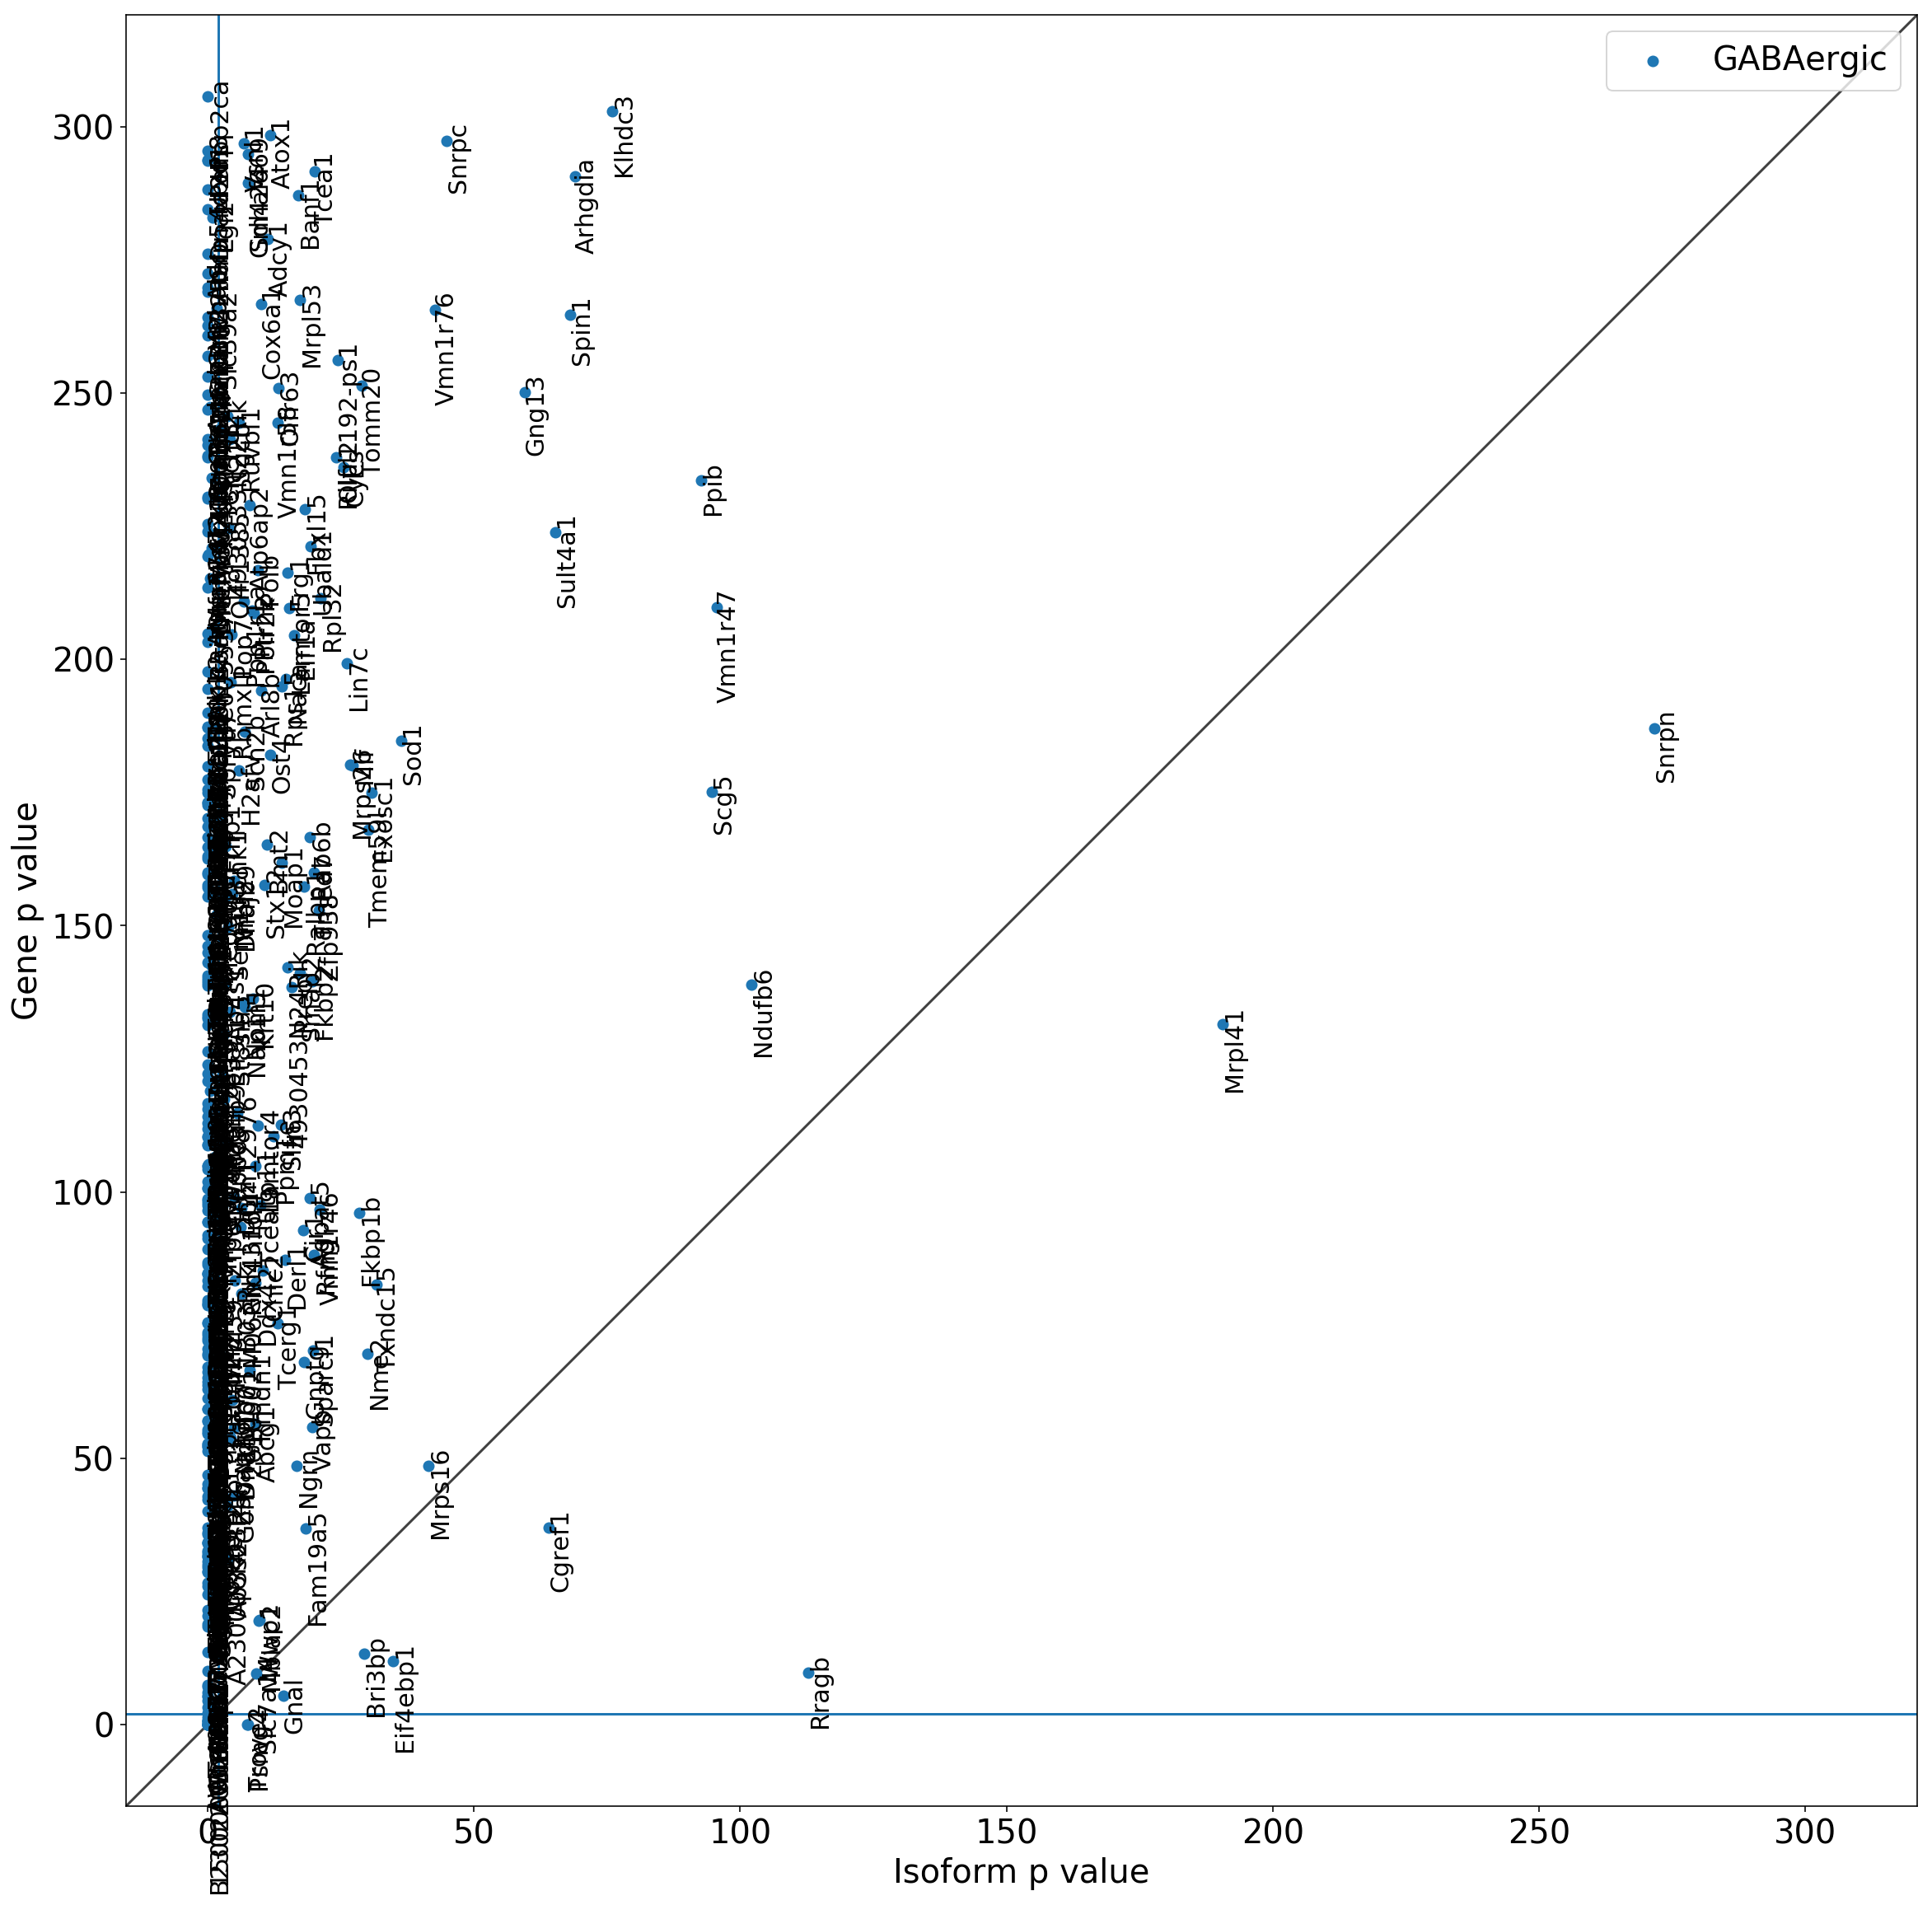

In [100]:
fig, ax = plt.subplots(figsize=(20,20))

cnum = 0

x = pval_iso_corr[cnum]
y = pval_corr[cnum]

nx = (~np.isnan(x)).sum()
ny = (~np.isnan(y)).sum()

mask = np.logical_and(~np.isnan(x), ~np.isnan(y))

x = -np.log10(x[mask])
y = -np.log10(y[mask])

line = -np.log10(.01)#/(nx + ny))

ax.scatter(x, y, label=assignments[cnum])
ax.axvline(x=line)
ax.axhline(y=line)

ax.set_xlabel('Isoform p value')
ax.set_ylabel('Gene p value')

ax = plot_yex(ax)


for i, txt in enumerate(gene_names[mask]):
    if x[i] > line or y[i]>line:
        ax.annotate(txt, (x[i], y[i]), fontsize=fsize-5, rotation=90)
ax.legend(loc='upper right')

plt.show()

In [101]:
d = defaultdict()
ng = 20
for i in range(ng):
    d["gene_{}".format(i)] = ""
    
class_markers = pd.DataFrame(d, index=unique)

d = defaultdict()
for i in range(ng):
    d["pval_corr_{}".format(i)] = 1
    
class_pvals = pd.DataFrame(d, index=unique)

In [102]:
mat         = iso_ratio.X
components  = iso_ratio.obs.cell_id.values
features    = iso_ratio.var.gene_name.values
assignments = iso_ratio.obs.class_label.values

unique = np.unique(assignments)

for cidx, c in enumerate(unique):
    print(c)
    markers = print_top_features(features, pval_corr, pval_iso_corr, cnum=cidx)
    if markers.shape[0] < ng: markers = np.append(markers, [np.nan]*(ng-markers.shape[0]))
    elif markers.shape[0]>ng: markers = markers[:ng]
    class_markers.loc[c] = markers
    
    pmarkers =  print_top_features(features, pval_corr, pval_iso_corr, return_pvals=True,feature="isoform", cnum=cidx)
    if pmarkers.shape[0] < ng: pmarkers = np.append(pmarkers, [np.nan]*(ng-pmarkers.shape[0]))
    elif pmarkers.shape[0]>ng: pmarkers = pmarkers[:ng]
    class_pvals.loc[c] = pmarkers

GABAergic
Glutamatergic
Low Quality
Non-Neuronal


In [103]:
class_markers

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10,gene_11,gene_12,gene_13,gene_14,gene_15,gene_16,gene_17,gene_18,gene_19
GABAergic,Psmg4,Trove2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Glutamatergic,Trove2,Sgpp1,Psmg4,4632415L05Rik,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Low Quality,Psmc2,Fkbp1b,Adcy1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Non-Neuronal,Ost4,Vmn1r13,Ppib,Pak2,Olfr1385,Trim6,Slc6a20b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
